# Model Core Utils

> core classes & helpers

In [ ]:
#| default_exp models.core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export

import torch.nn as nn
import torch
import torch.nn.functional as F
from torchmetrics import Accuracy, MaxMetric, MeanMetric, MinMetric
from torchmetrics.regression import MeanSquaredError
from torch_lr_finder import LRFinder
from torchinfo import summary

import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb
from lightning.pytorch.callbacks import LearningRateMonitor

from nimrod.image.datasets import ImageDataModule

from omegaconf import OmegaConf
from hydra.utils import instantiate

from abc import ABC, abstractmethod
import logging
import os
from typing import Any, Dict, List, Callable, Optional, Tuple
from functools import partial
from rich import print

import pandas as pd
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)

Seed set to 42
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Init
Apply init to layers with relu activations

In [ ]:
#| export
def weight_init(
        m:nn.Module, # the module to initialize
        leaky:int=0 # if leaky relu used
        ):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        nn.init.kaiming_normal_(m.weight, a=leaky)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=leaky)
        nn.init.constant_(m.bias, 0)

after conv: torch.Size([1, 3, 32, 32])

x flat dim:
torch.Size([1, 3, 1024])

after linear:
torch.Size([1, 3, 64])

Text(0.5, 1.0, 'kaiming init')

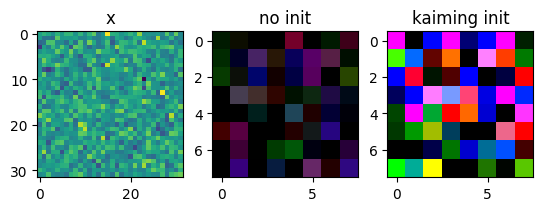

In [ ]:
x = torch.randn(1, 1, 32, 32)
in_channels = x.shape[1]
out_channels = 3
kernel_size = 3
stride = 1
c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size//2)
x1 = c1(x)
print(f"after conv: {x1.shape}")
print("x flat dim:", x1.flatten(2).shape)
l1 = nn.Linear(32*32, 64)
x2 = l1(x1.flatten(2))
print("after linear:", x2.shape)

leaky = 0.01
nnet = nn.Sequential(c1, nn.LeakyReLU(negative_slope=leaky), nn.Flatten(2), l1)
nnet.eval().cpu()
fig, ax = plt.subplots(1, 3)
ax[0].imshow(x.permute(0,2,3,1).squeeze())
ax[0].set_title("x")
y = nnet(x)
ax[1].imshow(y.detach().squeeze(0).permute(1,0).reshape(8, 8, 3))
ax[1].set_title("no init")
wi = partial(weight_init, leaky=leaky)
nnet.apply(wi)
y = nnet(x)
ax[2].imshow(y.detach().squeeze(0).permute(1,0).reshape(8, 8, 3))
ax[2].set_title("kaiming init")

## Classifier Abstract Base Class

In [ ]:
#| export

class Classifier(ABC, L.LightningModule):
    def __init__(
            self,
            nnet: nn.Module,
            num_classes:int,
            optimizer: Callable[...,torch.optim.Optimizer], # partial of optimizer
            scheduler: Optional[Callable[...,Any]]=None, # partial of scheduler
            ):

        logger.info("Classifier: init")
        super().__init__()
        self.save_hyperparameters()

        self.nnet = nnet
        self.register_module('nnet', self.nnet)
        self.lr = optimizer.keywords.get('lr') if optimizer else None # for lr finder

        self.automatic_optimization = False
        self.loss = nn.CrossEntropyLoss()
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        self.val_acc_best = MaxMetric()
        self.step = 0

        # self.optimizer_config = None
        # self.scheduler_config = None
        # self.nnet_config = None
        

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer = self.hparams.optimizer(params=self.trainer.model.parameters())
        self.optimizer = optimizer
        logger.info(f"Optimizer: {optimizer.__class__}")

        if self.hparams.scheduler is None:
            logger.warning("no scheduler has been setup")
            return {"optimizer": optimizer}
        
        scheduler = self.hparams.scheduler(optimizer=optimizer)
        self.scheduler = scheduler
        logger.info(f"Scheduler: {scheduler.__class__}")

        scheduler_config = {"scheduler": scheduler}
        
        # Special handling for different scheduler types
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler_config.update({
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1,
            })
        elif isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler_config.update({
                "interval": "step",
            })
        else:
            # Default configuration for other scheduler types
            scheduler_config.update({
                "interval": "epoch",
            })
        # setup config to be able to save in wandb
        # self.optimizer_config = {
        #     'type': optimizer.__class__.__name__,
        #     'params': optimizer.defaults
        # }
        # self.scheduler_config = {
        #     'type': scheduler.__class__.__name__,
        #     'params': scheduler.__dict__
        # }
        # self.nnet_config = {
        #     'type': self.nnet.__class__.__name__,
        #     'architecture': str(self.nnet),

        # }
        # if self.logger and hasattr(self.logger, 'experiment'):
        #     self.logger.experiment.config.update({
        #         'optimizer_config': self.optimizer_config,
        #         'scheduler_config': self.scheduler_config,
        #         'nnet_config': self.nnet_config
        #     }, allow_val_change=True)

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler_config,
        }
    
    @abstractmethod
    def _step(self, batch, batch_idx):
        pass

    @abstractmethod
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        pass

    def on_train_start(self) -> None:
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_acc.reset()
        self.val_acc_best.reset()

    def training_step(self, batch, batch_idx):

        # if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
        #     logger.info("scheduler is instance of OneCycleLR")
        #     if self.step >= self.scheduler.total_steps:
        #         logger.warning("Max steps reached for 1-cycle LR scheduler")
        #         return
        
        self.step += 1

        opt = self.optimizers() # optimizer defined in configure_optimizers
        sched = self.lr_schedulers() # access scheduler defined in configure_optimizers
         
        opt.zero_grad()
        loss, preds, y = self._step(batch, batch_idx)
        self.manual_backward(loss)
        opt.step()

        if not isinstance(sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
            sched.step() #reduce plateau sched is updated at end of epoch only instead TODO: should it be applied to val loop by default?

        self.train_loss(loss)
        self.train_acc(preds, y)
        metrics = {"train/loss": self.train_loss, "train/acc": self.train_acc}
        self.log_dict(metrics, on_epoch=True, on_step=True, prog_bar=True)# Pass the validation loss to the scheduler

        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch, batch_idx, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True):
        loss, preds, y = self._step(batch, batch_idx)
        self.val_loss(loss)
        self.val_acc(preds, y)
        metrics = {"val/loss":self.val_loss, "val/acc": self.val_acc}
        self.log_dict(metrics, on_step=on_step, prog_bar=prog_bar, on_epoch=on_epoch, sync_dist=sync_dist)
        return loss

    def on_validation_epoch_end(self) -> None:
        "Lightning hook that is called when a validation epoch ends."
        acc = self.val_acc.compute()  # get current val acc
        self.val_acc_best(acc)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/acc_best", self.val_acc_best.compute(), sync_dist=True, prog_bar=True)
        
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau):
            logger.info("scheduler is an instance of Reduce plateau")
            sch.step(self.trainer.callback_metrics["val/loss"])

    def test_step(self, batch, batch_idx, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True):
        loss, preds, y = self._step(batch, batch_idx)
        self.test_loss(loss)
        self.test_acc(preds, y)
        metrics = {"test/loss":self.test_loss, "test/acc": self.test_acc}
        self.log_dict(metrics, on_step=on_step, prog_bar=prog_bar, on_epoch=on_epoch, sync_dist=sync_dist)
    
    def on_test_epoch_end(self) -> None:
        """Lightning hook that is called when a test epoch ends."""
        pass


In [ ]:
#| export 

def plot_classifier_metrics_from_csv(metrics_csv_path:str | os.PathLike):
    metrics = pd.read_csv(metrics_csv_path)
    # Create figure with secondary y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot loss
    ax1.plot(metrics['step'], metrics['train/loss_step'], 'b-', label='Train Loss')
    ax1.plot(metrics['step'], metrics['val/loss'], 'b*', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot accuracy
    ax2.plot(metrics['step'], metrics['train/acc_step'], 'r-', label='Train Acc')
    ax2.plot(metrics['step'], metrics['val/acc'], 'r*', label='Val Acc')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Training Metrics')
    plt.show()

## Regressor Abstract Class

In [ ]:
#| export

class Regressor(ABC, L.LightningModule):
    def __init__(
        self,
        nnet: L.LightningModule,
        optimizer: Callable[...,torch.optim.Optimizer], # partial of optimizer
        scheduler: Optional[Callable[...,Any]]=None, # partial of scheduler

    ):
        logger.info("Regressor: init")
        super().__init__()
        self.save_hyperparameters()
        self.lr = optimizer.keywords.get('lr') if optimizer else None # for lr finder
        self.nnet = nnet
        # explicitely register nnet as a  module to track its parameters
        self.register_module('nnet', self.nnet)

        # loss
        self.criterion = nn.MSELoss()

        # loss accross batches
        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()
        self.val_mse_best = MinMetric()

        # average accross batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)

    def configure_optimizers(self):
        logger.info("Regressor: configure_optimizers")
        self.optimizer = self.hparams.optimizer(params=self.parameters())
        logger.info(f"Optimizer: {self.optimizer.__class__}")
        if self.hparams.scheduler is None:
            logger.warning("no scheduler has been setup")
            return {"optimizer": self.optimizer}
        self.scheduler = self.hparams.scheduler(optimizer=self.optimizer)
        if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
            lr_scheduler = {
                "scheduler": self.scheduler,
                "interval": "step",
                "frequency": 1,
            }
        else:
            lr_scheduler = {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1,
            }
        logger.info(f"Scheduler: {self.scheduler.__class__}")
        return {"optimizer": self.optimizer, "lr_scheduler": lr_scheduler}

    def on_train_start(self) -> None:
        self.val_loss.reset()
        self.val_mse.reset()
        self.val_mse_best.reset()
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat

    def _step(self, batch:Tuple[torch.Tensor, torch.Tensor], batch_idx:int):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        return loss, y_hat, y

    def training_step(self, batch, batch_idx):
        loss, y_hat, y = self._step(batch, batch_idx)
        self.train_loss(loss)
        self.train_mse(y_hat, y)
        # self.log("train/mse", self.train_mse, on_epoch=True, on_step=True, prog_bar=True)
        self.log("train/loss", self.train_loss, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self) -> None:
        pass

    def validation_step(self, batch, batch_idx):
        loss, y_hat, y = self._step(batch, batch_idx)
        self.val_loss(loss)
        self.val_mse(y_hat, y)
        # self.log("val/mse", self.val_mse, on_epoch=True, on_step=True, prog_bar=True)
        self.log("val/loss", self.val_loss, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
    
    def on_validation_epoch_end(self) -> None:
        mse = self.val_mse.compute()  # get current val acc
        self.val_mse_best(mse)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/mse_best", self.val_mse_best.compute(), sync_dist=True, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        loss, y_hat, y = self._step(batch, batch_idx)
        self.test_loss(loss)
        self.test_mse(y_hat, y)
    
        # self.log("test/mse", self.test_mse, on_epoch=True, on_step=True, prog_bar=True)
        self.log("test/loss", self.test_loss, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)

    def on_test_epoch_end(self) -> None:
        pass



## Diffuser Abstract Class

In [ ]:
#| export

class Diffuser(ABC, L.LightningModule):
    def __init__(
        self,
        nnet: L.LightningModule,
        optimizer: Callable[...,torch.optim.Optimizer], # partial of optimizer
        scheduler: Optional[Callable[...,Any]]=None, # partial of scheduler

    ):
        logger.info("Diffuser: init")
        super().__init__()
        self.save_hyperparameters()
        self.lr = optimizer.keywords.get('lr') if optimizer else None # for lr finder
        self.nnet = nnet
        # explicitely register nnet as a  module to track its parameters
        self.register_module('nnet', self.nnet)

        # loss
        self.criterion = nn.MSELoss()

        # average accross batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()
        self.val_loss_best = MinMetric()

    def forward(self, x:torch.Tensor, t:torch.Tensor)->torch.Tensor:
        return self.nnet(x, t)

    def configure_optimizers(self):
        logger.info("Regressor: configure_optimizers")
        self.optimizer = self.hparams.optimizer(params=self.parameters())
        logger.info(f"Optimizer: {self.optimizer.__class__}")
        if self.hparams.scheduler is None:
            logger.warning("no scheduler has been setup")
            return {"optimizer": self.optimizer}
        self.scheduler = self.hparams.scheduler(optimizer=self.optimizer)
        if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
            lr_scheduler = {
                "scheduler": self.scheduler,
                "interval": "step",
                "frequency": 1,
            }
        else:
            lr_scheduler = {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1,
            }
        logger.info(f"Scheduler: {self.scheduler.__class__}")
        return {"optimizer": self.optimizer, "lr_scheduler": lr_scheduler}

    def on_train_start(self) -> None:
        self.val_loss.reset()
        self.val_loss_best.reset()
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat

    def _step(self, batch:Tuple[torch.Tensor, torch.Tensor], batch_idx:int):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        return loss, y_hat, y

    def training_step(self, batch, batch_idx):
        loss, y_hat, y = self._step(batch, batch_idx)
        self.train_loss(loss)
        self.train_mse(y_hat, y)
        # self.log("train/mse", self.train_mse, on_epoch=True, on_step=True, prog_bar=True)
        self.log("train/loss", self.train_loss, on_epoch=True, on_step=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self) -> None:
        pass

    def validation_step(self, batch, batch_idx):
        loss, y_hat, y = self._step(batch, batch_idx)
        self.val_loss(loss)
        self.val_mse(y_hat, y)
        # self.log("val/mse", self.val_mse, on_epoch=True, on_step=True, prog_bar=True)
        self.log("val/loss", self.val_loss, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
    
    def on_validation_epoch_end(self) -> None:
        mse = self.val_mse.compute()  # get current val acc
        self.val_mse_best(mse)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/mse_best", self.val_mse_best.compute(), sync_dist=True, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        loss, y_hat, y = self._step(batch, batch_idx)
        self.test_loss(loss)
        self.test_mse(y_hat, y)
    
        # self.log("test/mse", self.test_mse, on_epoch=True, on_step=True, prog_bar=True)
        self.log("test/loss", self.test_loss, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)

    def on_test_epoch_end(self) -> None:
        pass



## Sequential Model

In [ ]:
#| export
class SequentialModelX(Classifier):
    def __init__(self, modules: List[nn.Module], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._model = nn.Sequential(*modules)

    def forward(self, x):
        return self._model(x)

## LR Finder Helper

In [ ]:
# use LRFinder pythonm module (other version with lightning)

def find_optimal_lr(model, train_loader, criterion=None, optimizer=None, device='cuda'):
    # If no criterion provided, use default CrossEntropyLoss
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    # If no optimizer provided, use Adam
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    
    # Initialize LR Finder
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
    # Run LR range test
    lr_finder.range_test(
        train_loader, 
        start_lr=1e-7,  # Very small starting learning rate
        end_lr=10,      # Large ending learning rate
        num_iter=100,   # Number of iterations to test
        smooth_f=0.05   # Smoothing factor for the loss
    )
    
    # Plot the learning rate vs loss
    lr_finder.plot(log_lr=True)
    
    # Suggest optimal learning rate
    suggested_lr = lr_finder.reset()
    
    print(f"Suggested Learning Rate: {suggested_lr}")
    
    return suggested_lr




In [ ]:
#| export

def lr_finder(
    model: Callable[...,torch.nn.Module], # partial model (missing optim & sched)
    datamodule: ImageDataModule, # data module
    num_training:int=100, # number of iterations
    plot:bool=True # plot the learning rate vs loss
    ):

    trainer = Trainer(accelerator="auto")
    tuner = Tuner(trainer)
    optimizer = partial(torch.optim.AdamW, lr=1e-4, weight_decay=1e-5)
    model = model(optimizer=optimizer, scheduler=None)
    lr_finder = tuner.lr_find(
        model,
        datamodule=datamodule,
        min_lr=1e-5,
        max_lr=1.0,
        num_training=num_training,  # number of iterations
        # attr_name="optimizer.lr",
    )
    
    if plot:
        _ = lr_finder.plot(suggest=True)
        plt.show()
    return lr_finder.suggestion()

## 1-cycle train helper

In [ ]:
#| export

def train_one_cycle(
    model: Callable[...,torch.nn.Module], #partial model (missing optim & sched)
    datamodule: ImageDataModule,
    max_lr:float=0.1,
    weight_decay=1e-5,
    n_epochs:int=5,
    project_name:str='MNIST-Classifier',
    tags = ['arch', 'dev'],
    test:bool=True,
    run_name:str=None,
    model_summary:bool=True,
    logger_cb:str='wandb',
    precision="32-true", # 16-mixed, 32-true
    ):

    """train one cycle, adamW optim with wandb logging & learning rate monitor by default"""

    model_name = model.func.__name__ 
    if run_name is None:
        run_name = f"{model_name}-bs:{datamodule.batch_size}-epochs:{n_epochs}"
    
    # logger
    if logger_cb=='wandb':

        exp_logger = WandbLogger(
            project=project_name,
            name=run_name,
            save_dir='wandb',
            entity='slegroux',
            tags=tags,
            group=model_name,
            log_model=True, # log artefacts at the end of run
            # monitor_gym=False,
            mode='online',
            )
    else:
        exp_logger = TensorBoardLogger(
            save_dir='./tensorboard',
            log_graph=True,
            default_hp_metric=True
            )
    # lr monitor
    lr_monitor = LearningRateMonitor(logging_interval="step")

    # checkpoint callback
    ckpt_cb = ModelCheckpoint(
        dirpath=f"checkpoints/{project_name}/{run_name}",
        filename='{epoch}-{val/loss:.2f}',
        auto_insert_metric_name=False,
        monitor="val/loss",
        mode="min",
        save_top_k=1,
        save_last=True,
    )

    trainer = Trainer(
        accelerator="auto",
        max_epochs=n_epochs,
        logger=exp_logger,
        callbacks = [lr_monitor, ckpt_cb],
        check_val_every_n_epoch=1,
        log_every_n_steps=1,
        precision=precision
        )

    total_steps = len(datamodule.train_dataloader()) * n_epochs
    optimizer = partial(torch.optim.AdamW, lr=1e-4, weight_decay=weight_decay)
    scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, total_steps=total_steps, max_lr=max_lr) 
    model = model(optimizer=optimizer, scheduler=scheduler)

    if model_summary:
        xb, yb = next(iter(datamodule.train_dataloader()))
        print(summary(model.nnet, input_size=xb.shape, depth=3, device='cpu'))
    
    trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())
    if test:
        trainer.test(model, datamodule.test_dataloader())
    logger.info(f"Best ckpt path: {ckpt_cb.best_model_path}")
    wandb.finish()
    return model, ckpt_cb.best_model_path

In [ ]:
#| notest

# data
cfg = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
cfg.data_dir = "../data/image"
cfg.batch_size = 128
cfg.num_workers = 0
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[21:54:44] INFO - Init ImageDataModule for fashion_mnist
[21:54:46] INFO - loading dataset fashion_mnist with args () from split train
[21:54:46] INFO - loading dataset fashion_mnist from split train
Overwrite dataset info from restored data version if exists.
[21:54:48] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2
[21:54:48] INFO - Loading Dataset info from ../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2
Found cached dataset fashion_mnist (/user/s/slegroux/Projects/nimrod/nbs/../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2)
[21:54:48] INFO - Found cached dataset fashion_mnist (/user/s/slegroux/Projects/nimrod/nbs/../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2)
Loading Dataset info from /user/s/slegroux/Projects/nimrod/nbs/../da

In [ ]:
#| notest
# model
cfg_model = OmegaConf.load('../config/model/image/convnetx.yaml')
feats_dim = [1, 8, 16, 32, 64, 128]
# feats_dim = [1, 4, 8, 16, 8]
# feats_dim = [1, 16, 32, 64, 32]
cfg_model.nnet.n_features = feats_dim
model = instantiate(cfg_model) #partial
do_lr_finder = False

if do_lr_finder:
    suggested_lr = lr_finder(model=model, datamodule=dm, plot=True)
else:
    suggested_lr = 1e-3

# train
N_EPOCHS = 1

project_name = "FASHION-MNIST-Classifier"
run_name = f"{model.func.__name__}-bs:{dm.batch_size}-epochs:{N_EPOCHS}"
tags = [f"feats:{feats_dim}", f"bs:{dm.batch_size}", f"epochs:{N_EPOCHS}"]

trained_model, best_ckpt = train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name=project_name,
    tags=tags,
    run_name=run_name
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[21:54:54] INFO - ConvNetX: init
[21:54:54] INFO - Classifier: init
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
ConvNet                                  [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─ConvLayer: 2-1                    [128, 8, 32, 32]          --
│    │    └─Sequential: 3-1              [128, 8, 32, 32]          88
│    └─ConvLayer: 2-2                    [128, 16, 16, 16]         --
│    │    └─Sequential: 3-2              [128, 16, 16, 16]         1,184
│    └─ConvLayer: 2-3                    [128, 32, 8, 8]           --
│    │    └─Sequential: 3-3              [128, 32, 8, 8]           4,672
│    └─ConvLayer: 2-4                    [128, 64, 4, 4]           --
│    │    └─Sequential: 3-4              [128, 64, 4, 4]           18,560
│    └─ConvLayer: 2-5                    [128, 128, 2, 2]          --
│    │    └─Sequential: 3-5              [128, 128, 2, 2]          73,984
│    └─ConvLayer: 2-6                    [128, 10, 1, 1]           --
│    │    └─Sequential: 3-6              [128, 10, 1, 1]           11,540
│    └─Flatten: 2-7                      [128, 10]                 --
==========================================================================================
Total params: 110,028
Trainable params: 110,028
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 161.97
==========================================================================================
Input size (MB): 0.52
Forward/backward pass size (MB): 32.53
Params size (MB): 0.44
Estimated Total Size (MB): 33.49
==========================================================================================

/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /user/s/slegroux/Projects/nimrod/nbs/checkpoints/FASHION-MNIST-Classifier/ConvNetX-bs:128-epochs:1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[21:54:54] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[21:54:54] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | nnet         | ConvNet            | 110 K  | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | train_acc    | MulticlassAccuracy | 0      | train
3 | val_acc      | MulticlassAccuracy | 0      | train
4 | test_acc     | MulticlassAccuracy | 0      | train
5 | train_loss   | MeanMetric         | 0      | train
6 | val_loss     | MeanMetric         | 0      | train
7 | test_loss    | MeanMetric         | 0      | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.8658000230789185     │
│         test/loss         │    0.5964178442955017     │
└───────────────────────────┴───────────────────────────┘

[21:55:01] INFO - Best ckpt path: /user/s/slegroux/Projects/nimrod/nbs/checkpoints/FASHION-MNIST-Classifier/ConvNetX-bs:128-epochs:1/0-0.57.ckpt


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-AdamW,▁▁▂▂▃▃▄▅▅▅▆▆▇██████████▇▇▆▅▅▅▅▄▄▄▃▃▂▁▁▁▁
test/acc,▁
test/loss,▁
train/acc_epoch,▁
train/acc_step,▁▂▄▅▅▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇█▇▇██▇▇███▇▇██▇██▇█
train/loss_epoch,▁
train/loss_step,█▇▆▆▆▄▃▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
val/acc,▁
val/acc_best,▁


In [ ]:
#| notest
print(best_ckpt)
x = torch.randn(1, 1, 32, 32)
trained_model.eval()
trained_model(x)

/user/s/slegroux/Projects/nimrod/nbs/checkpoints/FASHION-MNIST-Classifier/ConvNetX-bs:128-epochs:1/0-0.58.ckpt

tensor([[0.0000, 0.0000, 0.5579, 0.1776, 0.0000, 0.3419, 0.0000, 0.0000, 2.2810,
         0.0000]], grad_fn=<ViewBackward0>)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()